<a href="https://colab.research.google.com/github/shanvelc/CDS-ML/blob/main/M3_MP4_SNB_with_Kaggle_Employee_Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics

## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). It is a fictional dataset created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1eExeVCNdtblBWmtYJ3iNWboFzZbbfal4/view?usp=drive_link) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.

## Grading = 10 Points

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Install CatBoost

In [2]:
!pip -qq install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.3 MB/s eta 0:00:00


### Import Required Packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [4]:
ibm_df = pd.read_csv('/content/hr_employee_attrition_train.csv')
ibm_df.head()

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,45,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,2,Female,93,2,2,Manufacturing Director,4,Married,5906,23888,0,Y,No,13,3,4,80,2,10,2,2,9,8,3,8,No
1,34,Travel_Rarely,970,Research & Development,8,2,Medical,1,757,2,Female,96,3,2,Healthcare Representative,3,Single,6142,7360,3,Y,No,11,3,4,80,0,10,2,3,5,1,4,3,No
2,39,Travel_Rarely,360,Research & Development,23,3,Medical,1,1310,3,Male,93,3,1,Research Scientist,1,Single,3904,22154,0,Y,No,13,3,1,80,0,6,2,3,5,2,0,3,Yes
3,26,Travel_Rarely,933,Sales,1,3,Life Sciences,1,476,3,Male,57,3,2,Sales Executive,3,Married,5296,20156,1,Y,No,17,3,2,80,1,8,3,3,8,7,7,7,No
4,40,Travel_Rarely,329,Research & Development,1,4,Life Sciences,1,1361,2,Male,88,3,1,Laboratory Technician,2,Married,2387,6762,3,Y,No,22,4,3,80,1,7,3,3,4,2,0,3,No


In [5]:
ibm_df.shape

(1170, 35)

In [6]:
ibm_df.over18.value_counts()

,count
over18,
Y,1170


In [7]:
ibm_df.employeecount.value_counts()

,count
employeecount,
1,1170


The above features that is employeecount and over18 has only one value throughout the records. Hence, they will be dropped.


In [8]:
ibm_df = ibm_df.drop(['employeenumber', 'employeecount','over18'], axis=1)
ibm_df.head(5)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,45,Travel_Rarely,556,Research & Development,25,2,Life Sciences,2,Female,93,2,2,Manufacturing Director,4,Married,5906,23888,0,No,13,3,4,80,2,10,2,2,9,8,3,8,No
1,34,Travel_Rarely,970,Research & Development,8,2,Medical,2,Female,96,3,2,Healthcare Representative,3,Single,6142,7360,3,No,11,3,4,80,0,10,2,3,5,1,4,3,No
2,39,Travel_Rarely,360,Research & Development,23,3,Medical,3,Male,93,3,1,Research Scientist,1,Single,3904,22154,0,No,13,3,1,80,0,6,2,3,5,2,0,3,Yes
3,26,Travel_Rarely,933,Sales,1,3,Life Sciences,3,Male,57,3,2,Sales Executive,3,Married,5296,20156,1,No,17,3,2,80,1,8,3,3,8,7,7,7,No
4,40,Travel_Rarely,329,Research & Development,1,4,Life Sciences,2,Male,88,3,1,Laboratory Technician,2,Married,2387,6762,3,No,22,4,3,80,1,7,3,3,4,2,0,3,No


In [9]:
# Shape of dataframe
ibm_df.shape

(1170, 32)

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

### Description

In [10]:
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in ibm_df.columns:
    obs = ibm_df[col].size
    p_nan = round(ibm_df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({ibm_df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if ibm_df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(ibm_df[col].unique())} labels' if dtype == 'categorical' else f'{ibm_df[col].min()}-{ibm_df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

#numerical.remove('employeecount')
numerical.remove('standardhours')
pd.set_option('display.max_columns', 100)
display(description)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
observations(rows),1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170
percent missing,0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170),0.0% (0/1170)
dtype,numerical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,categorical
range,18-60,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,2 labels,11-25,3-4,1-4,80-80,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17,2 labels


The data isn't missing any values and we can spend more time on comparing different gradient boosted tree algorithms. First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

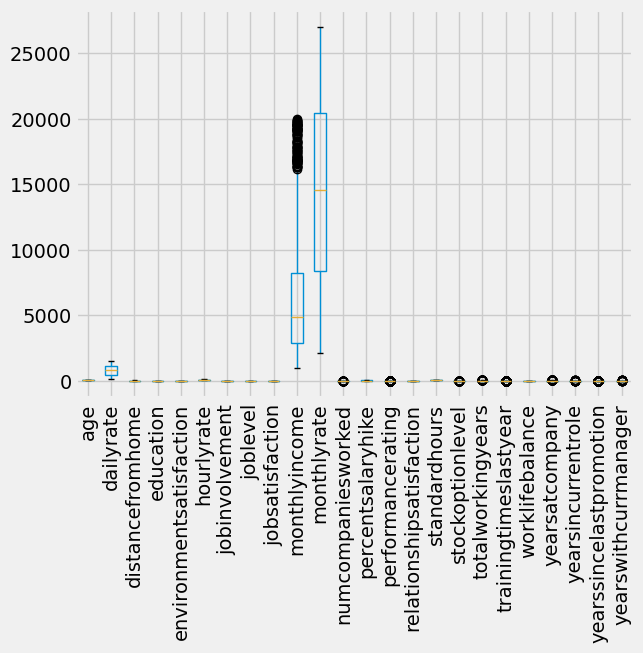

In [11]:
# Check for outliers
ibm_df.boxplot(rot = 90)
plt.show()

### Handing outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [12]:
outlier_colms = ['monthlyincome', 'numcompaniesworked', 'stockoptionlevel',  'performancerating', 'totalworkingyears',
                 'trainingtimeslastyear', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']
ibm_df1 = ibm_df.copy()

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

for colm in outlier_colms:
    ibm_df1 = handle_outliers(ibm_df1, colm)

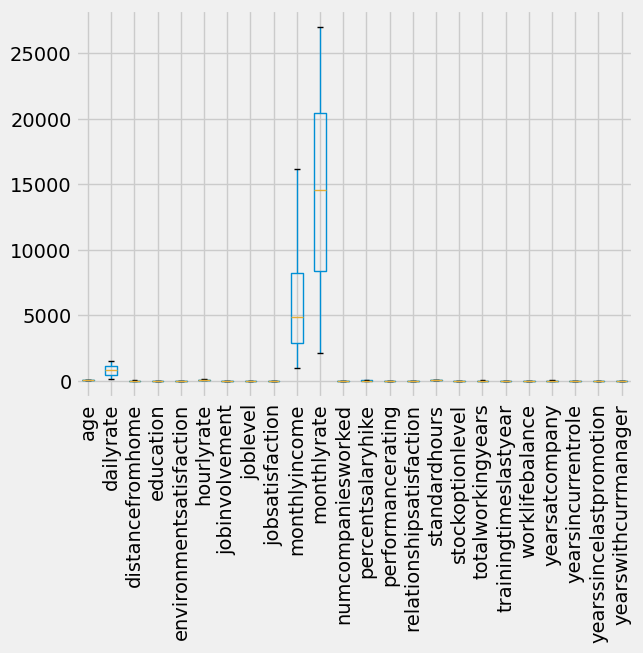

In [13]:
# Recheck for outliers
ibm_df1.boxplot(rot = 90)
plt.show()

### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

In [14]:
# Count of unique values in Attrition column
attrition_values = ibm_df1['attrition'].value_counts()
attrition_values

,count
attrition,
No,981
Yes,189


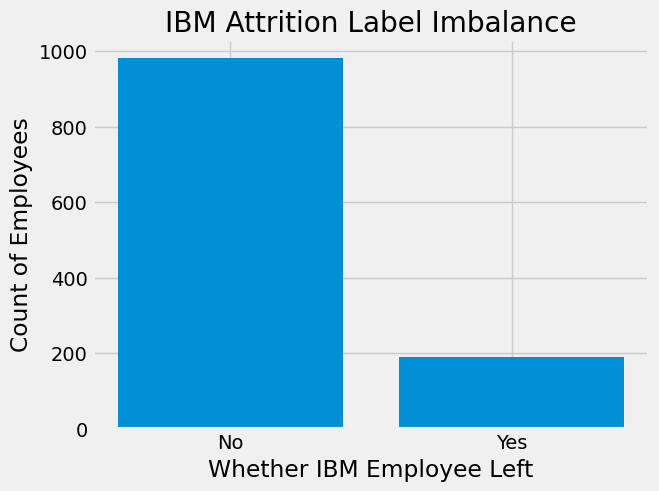

In [15]:
# Plot barplot
plt.bar(attrition_values.index, attrition_values.values)
plt.title('IBM Attrition Label Imbalance')
plt.xlabel('Whether IBM Employee Left')
plt.ylabel('Count of Employees')
plt.show()

###Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

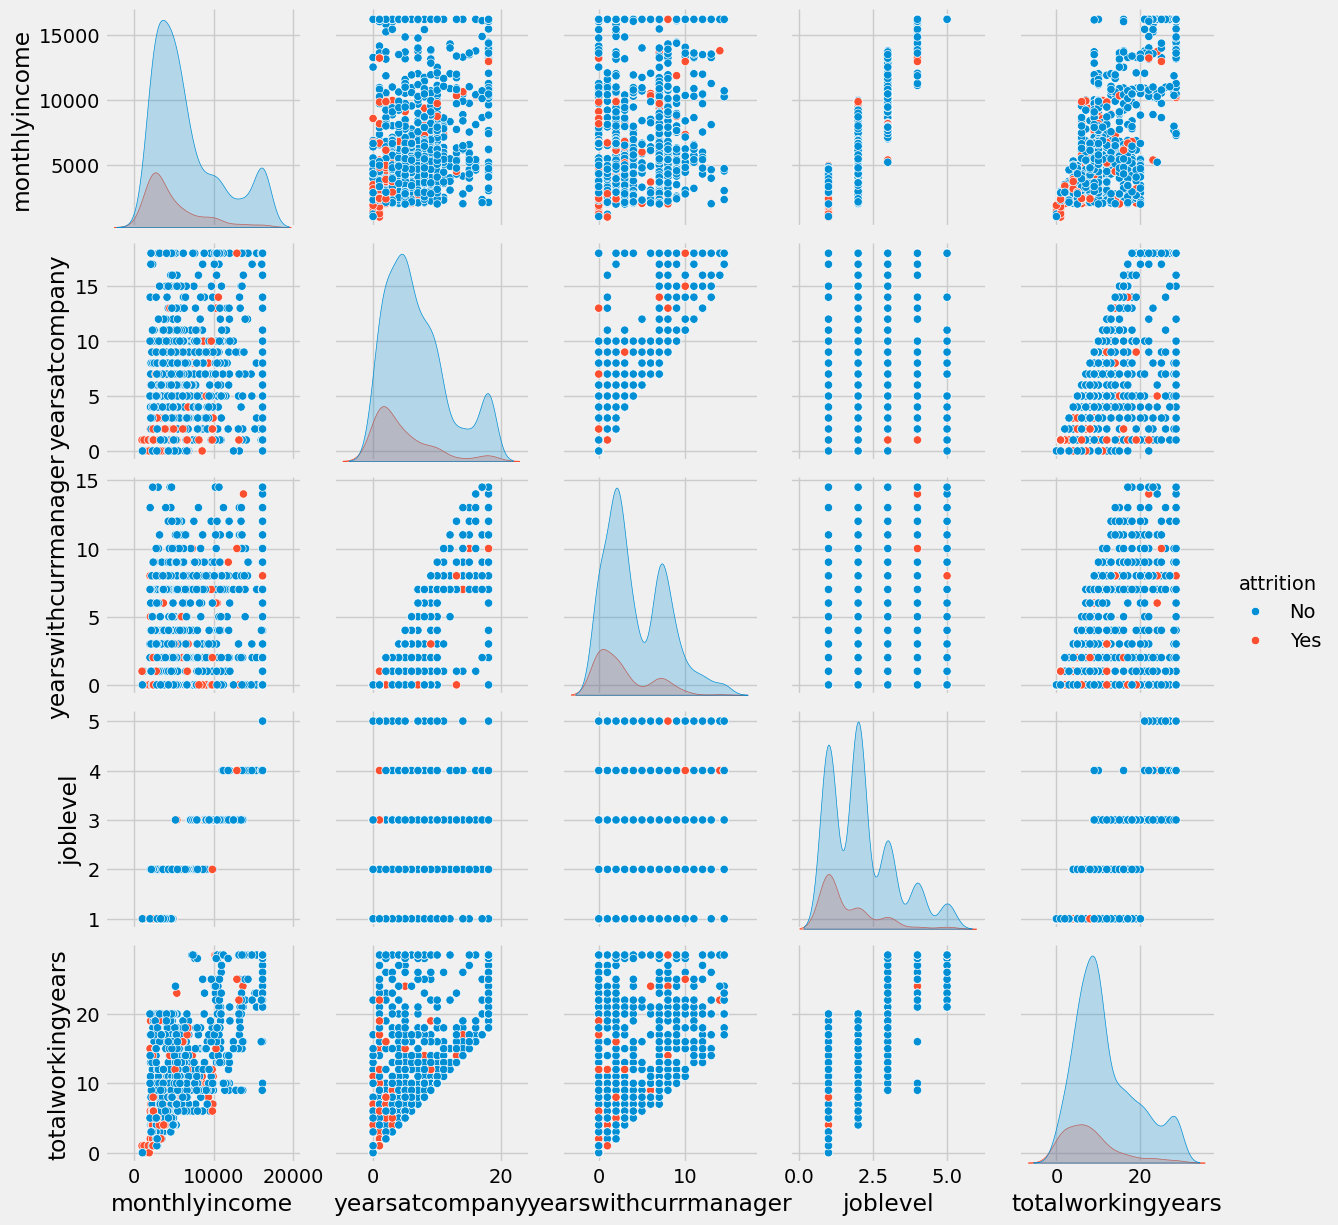

In [16]:
# Visualize a pirplot with few feature
features = ['monthlyincome', 'attrition', 'yearsatcompany', 'yearswithcurrmanager', 'joblevel', 'totalworkingyears']
pairplot = sns.pairplot(ibm_df1[features], diag_kind='kde', hue='attrition')
plt.show()

From the results it can see that the data has an imbalance in target labels. It has about a 6:1 *No* attrition label compared to *Yes*. The effect of the imbalance really shows up in the pairplots where the *yes* markers in the scatter plots are all but drowned out, though this would be less of a problem if the classes were more distinct. To test the model a smart thing to do would be to look at the confusion matrix and see how well the model performed on the minority class, *yes*.

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

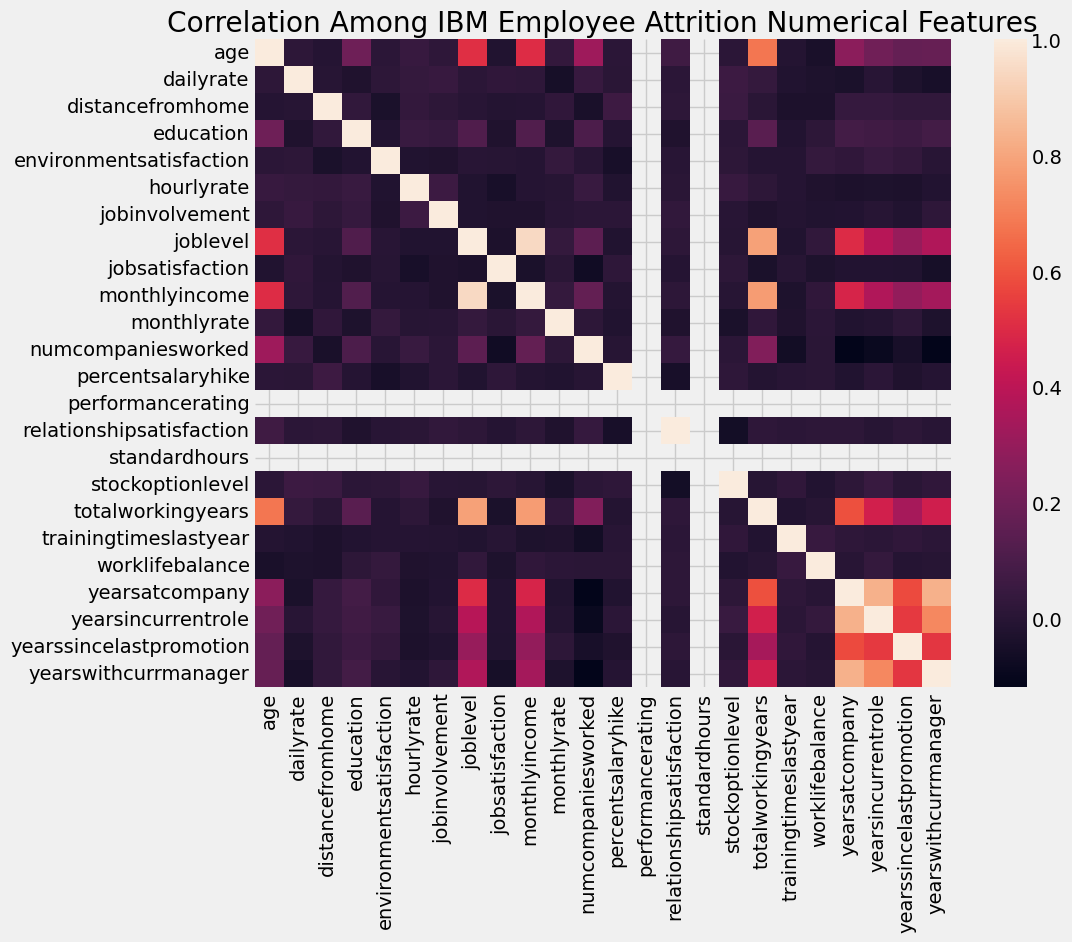

In [17]:
# Visualize heatmap
plt.figure(figsize = (10, 8))
numerical_ibm_df1 = ibm_df1.select_dtypes(include=['number'])
sns.heatmap(numerical_ibm_df1.corr())
plt.title('Correlation Among IBM Employee Attrition Numerical Features')
plt.show()

In the pairplot, from the diagonal distributions it seems that there are no features that have drastically different distributions between the classes.

Lastly, plot the correlations between the features to look for colinear relationships. These are usually a problem for GBDTs but if there are many features with high correlation, some feature engineering can be done.

### Preparing the Validation Data

In [18]:
# Split into training and validation set
train_ibm_df, test_ibm_df = train_test_split(ibm_df1, test_size = 0.05, stratify = ibm_df1['attrition'], random_state = 123)
train_ibm_df.shape, test_ibm_df.shape

((1111, 32), (59, 32))

In [19]:
print("Attrition train")
print(train_ibm_df['attrition'].value_counts()/len(train_ibm_df))
print("Attrition test")
print(test_ibm_df['attrition'].value_counts()/len(test_ibm_df))

Attrition train
attrition
No     0.838884
Yes    0.161116
Name: count, dtype: float64
Attrition test
attrition
No     0.830508
Yes    0.169492
Name: count, dtype: float64


In [20]:
test_ibm_df.head()

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
985,35,Travel_Rarely,1361,Sales,17,4,Life Sciences,3,Male,94,3,2,Sales Executive,1,Married,8966,21026,3.0,Yes,15,3,4,80,2.5,15.0,2.0,3,7,7.0,1.0,7.0,No
85,51,Travel_Rarely,1318,Sales,26,4,Marketing,1,Female,66,3,4,Manager,3,Married,16166,5594,2.0,No,14,3,3,80,1.0,28.5,2.0,2,18,6.0,4.0,14.5,No
655,48,Travel_Rarely,1221,Sales,7,3,Marketing,3,Male,96,3,2,Sales Executive,1,Divorced,5486,24795,4.0,No,11,3,1,80,2.5,15.0,3.0,3,2,2.0,2.0,2.0,No
624,32,Travel_Rarely,414,Sales,2,4,Marketing,3,Male,82,2,2,Sales Executive,2,Single,9907,26186,7.0,Yes,12,3,3,80,0.0,7.0,3.0,2,2,2.0,2.0,2.0,Yes
1048,43,Travel_Rarely,930,Research & Development,6,3,Medical,1,Female,73,2,2,Research Scientist,3,Single,4081,20003,1.0,Yes,14,3,1,80,0.0,20.0,3.0,1,18,7.0,1.0,8.0,No


In [21]:
categorical

['businesstravel',
 'department',
 'educationfield',
 'gender',
 'jobrole',
 'maritalstatus',
 'overtime',
 'attrition']

In [22]:
# Handling categorical features in test set
test_dummy = pd.get_dummies(test_ibm_df[categorical], drop_first=True)
test_dummy.head()

,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition_Yes
985,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False
85,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
655,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
624,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True,True
1048,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False


In [23]:
# Concat encoded features
test_ibm_df = pd.concat([test_ibm_df, test_dummy], axis=1)
# Drop original categorical columns
test_ibm_df.drop(columns = categorical, inplace=True)
test_ibm_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition_Yes
985,35,1361,17,4,3,94,3,2,1,8966,21026,3.0,15,3,4,80,2.5,15.0,2.0,3,7,7.0,1.0,7.0,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False
85,51,1318,26,4,1,66,3,4,3,16166,5594,2.0,14,3,3,80,1.0,28.5,2.0,2,18,6.0,4.0,14.5,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
655,48,1221,7,3,3,96,3,2,1,5486,24795,4.0,11,3,1,80,2.5,15.0,3.0,3,2,2.0,2.0,2.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
624,32,414,2,4,3,82,2,2,2,9907,26186,7.0,12,3,3,80,0.0,7.0,3.0,2,2,2.0,2.0,2.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True,True
1048,43,930,6,3,1,73,2,2,3,4081,20003,1.0,14,3,1,80,0.0,20.0,3.0,1,18,7.0,1.0,8.0,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False


In [24]:
# Rename target column
test_ibm_df.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
test_ibm_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition
985,35,1361,17,4,3,94,3,2,1,8966,21026,3.0,15,3,4,80,2.5,15.0,2.0,3,7,7.0,1.0,7.0,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False
85,51,1318,26,4,1,66,3,4,3,16166,5594,2.0,14,3,3,80,1.0,28.5,2.0,2,18,6.0,4.0,14.5,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
655,48,1221,7,3,3,96,3,2,1,5486,24795,4.0,11,3,1,80,2.5,15.0,3.0,3,2,2.0,2.0,2.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
624,32,414,2,4,3,82,2,2,2,9907,26186,7.0,12,3,3,80,0.0,7.0,3.0,2,2,2.0,2.0,2.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True,True
1048,43,930,6,3,1,73,2,2,3,4081,20003,1.0,14,3,1,80,0.0,20.0,3.0,1,18,7.0,1.0,8.0,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False


In [25]:
# Features
test_x = test_ibm_df.drop('attrition', axis=1)
# Targer label
test_y = test_ibm_df['attrition']

test_x.shape, test_y.shape

((59, 45), (59,))

# Hyperopt (Optional)

In [26]:
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break

    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    F1 = round(trials[fit_idx]['result']['f1 score'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'f1_score': F1,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

Refer to the Additional Notebook: CatBoost parameter tuning [CDS-B8 GDrive -> Module 3 -> Assignments -> July 27, 2024 -> Additional Notebook (ungraded) -> Addl_NB_Tuning_hyerparameters_using_Hyperopt]

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks.

Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [27]:
cbo_data = train_ibm_df.copy()
cbo_data.shape

(1111, 32)

In [28]:
# Handling categorical features in train set
cbo_dummy = pd.get_dummies(cbo_data[categorical], drop_first=True)
cbo_dummy.head()

,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition_Yes
91,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
815,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1096,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False
303,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
318,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [29]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
cbo_data = pd.concat([cbo_data, cbo_dummy], axis=1)
cbo_data.drop(columns = categorical, inplace=True)
cbo_data.head(5)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition_Yes
91,33,536,10,5,4,82,4,3,3,8380,21708,0.0,14,3,4,80,2.0,10.0,3.0,3,9,8.0,0.0,8.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
815,29,1329,7,3,3,82,3,2,4,6623,4204,1.0,11,3,2,80,2.0,6.0,2.0,3,6,0.0,1.0,0.0,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1096,59,1089,1,2,2,66,3,3,4,11904,11038,3.0,14,3,3,80,1.0,14.0,1.0,1,6,4.0,0.0,4.0,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False
303,46,1034,18,1,1,86,3,3,3,10527,8984,5.0,11,3,4,80,0.0,28.0,3.0,2,2,2.0,1.0,2.0,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
318,33,575,25,3,4,44,2,2,2,4320,24152,1.0,13,3,4,80,0.0,5.0,2.0,3,5,3.0,0.0,2.0,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [30]:
# Rename target column
cbo_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
cbo_data.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition
91,33,536,10,5,4,82,4,3,3,8380,21708,0.0,14,3,4,80,2.0,10.0,3.0,3,9,8.0,0.0,8.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
815,29,1329,7,3,3,82,3,2,4,6623,4204,1.0,11,3,2,80,2.0,6.0,2.0,3,6,0.0,1.0,0.0,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1096,59,1089,1,2,2,66,3,3,4,11904,11038,3.0,14,3,3,80,1.0,14.0,1.0,1,6,4.0,0.0,4.0,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False
303,46,1034,18,1,1,86,3,3,3,10527,8984,5.0,11,3,4,80,0.0,28.0,3.0,2,2,2.0,1.0,2.0,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
318,33,575,25,3,4,44,2,2,2,4320,24152,1.0,13,3,4,80,0.0,5.0,2.0,3,5,3.0,0.0,2.0,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [31]:
# Features
x_df = cbo_data.drop('attrition', axis=1)
# Targer label
y_df = cbo_data['attrition']

x_df.shape, y_df.shape

((1111, 45), (1111,))

### SMOTE (Optional)

In [32]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

<Axes: ylabel='count'>

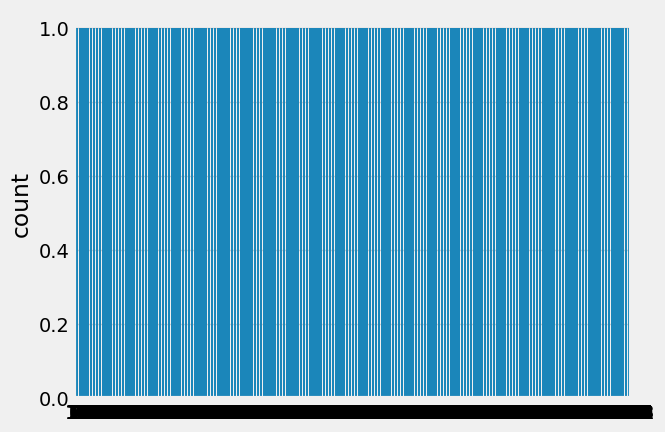

In [33]:
sns.countplot(y_df1, label = 'count')

After implementing SMOTE, x_df1 and y_df1 are the independent features and target labels simultaeneously.

If SMOTE is to be applied they can be used while training the model.

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.

In [34]:
# def cat_objective(space):

#     cboost = CatBoostClassifier(
#     eval_metric  = 'AUC',
#     learning_rate = space['learning_rate'],
#     iterations = space['iterations'],
#     depth = space['depth'],
#     l2_leaf_reg = space['l2_leaf_reg'],
#     border_count = space['border_count']
#     )

#     cboost.fit(x_df1, y_df1,
#             cat_features=None)

#     predictions = cboost.predict(test_x)
#     test_preds = cboost.predict_proba(test_x)[:,1]
#     train_preds = cboost.predict_proba(x_df1)[:,1]

#     train_auc = roc_auc_score(y_df1, train_preds)
#     test_auc = roc_auc_score(test_y, test_preds)
#     accuracy = accuracy_score(test_y, predictions)
#     F1 = f1_score(test_y, predictions)

#     return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
#             'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1}

Hyperparameter tuning technique to optimize parameters for CatBoost (Optional).

In [35]:
# trials = Trials()
# space = {
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
#     'iterations': hp.quniform('iterations', 25, 1000, 25),
#     'depth': hp.quniform('depth', 1, 16, 1),
#     'border_count': hp.quniform('border_count', 30, 220, 5),
#     'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
# }

# cboost_hyperparams = fmin(fn = cat_objective,
#                  max_evals = 150,
#                  trials = trials,
#                  algo = tpe.suggest,
#                  space = space
#                  )

# cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
# display(cbo_results)

In [36]:
# Create CatBoost model
cboost = CatBoostClassifier(learning_rate = 1,
                            depth = 1,
                            scale_pos_weight = 6,
                            l2_leaf_reg = 8,
                            border_count = 65)

In [37]:
cboost_dft = CatBoostClassifier()

In [38]:
cboost_dft.fit(x_df, y_df, cat_features = None)

Learning rate set to 0.010776
0:	learn: 0.6865257	total: 47.5ms	remaining: 47.5s
1:	learn: 0.6779407	total: 50.1ms	remaining: 25s
2:	learn: 0.6712107	total: 52.2ms	remaining: 17.3s
3:	learn: 0.6640779	total: 54.2ms	remaining: 13.5s
4:	learn: 0.6570893	total: 56.4ms	remaining: 11.2s
5:	learn: 0.6506755	total: 58.8ms	remaining: 9.75s
6:	learn: 0.6446432	total: 61.1ms	remaining: 8.67s
7:	learn: 0.6369546	total: 63.2ms	remaining: 7.84s
8:	learn: 0.6310202	total: 65.3ms	remaining: 7.19s
9:	learn: 0.6241418	total: 67.8ms	remaining: 6.71s
10:	learn: 0.6183332	total: 70.1ms	remaining: 6.3s
11:	learn: 0.6106797	total: 72.4ms	remaining: 5.96s
12:	learn: 0.6056506	total: 74.9ms	remaining: 5.69s
13:	learn: 0.5996376	total: 77.9ms	remaining: 5.49s
14:	learn: 0.5935024	total: 81.2ms	remaining: 5.33s
15:	learn: 0.5878624	total: 83.9ms	remaining: 5.16s
16:	learn: 0.5824525	total: 86.1ms	remaining: 4.98s
17:	learn: 0.5759404	total: 88.4ms	remaining: 4.82s
18:	learn: 0.5712269	total: 90.7ms	remaining: 4

`Hyperopt`, hyperparameter tuning technique was used to identify the best set of parameters.
* Different set of hyperparameters were giving good result.
* Out of them, one such set was chosen.

In [39]:
# Model training
cboost.fit(x_df, y_df, cat_features = None)

0:	learn: 0.6520016	total: 776us	remaining: 775ms
1:	learn: 0.6094611	total: 1.68ms	remaining: 837ms
2:	learn: 0.5831851	total: 2.53ms	remaining: 840ms
3:	learn: 0.5735135	total: 3.36ms	remaining: 836ms
4:	learn: 0.5628737	total: 4.28ms	remaining: 851ms
5:	learn: 0.5554670	total: 5.08ms	remaining: 842ms
6:	learn: 0.5491573	total: 5.83ms	remaining: 827ms
7:	learn: 0.5300908	total: 6.59ms	remaining: 818ms
8:	learn: 0.5188729	total: 7.39ms	remaining: 814ms
9:	learn: 0.5064971	total: 8.18ms	remaining: 810ms
10:	learn: 0.4951730	total: 8.93ms	remaining: 803ms
11:	learn: 0.4857894	total: 9.81ms	remaining: 808ms
12:	learn: 0.4769149	total: 10.7ms	remaining: 812ms
13:	learn: 0.4692795	total: 11.5ms	remaining: 808ms
14:	learn: 0.4639676	total: 12.2ms	remaining: 803ms
15:	learn: 0.4577982	total: 13ms	remaining: 799ms
16:	learn: 0.4507308	total: 13.8ms	remaining: 796ms
17:	learn: 0.4443847	total: 14.6ms	remaining: 795ms
18:	learn: 0.4380537	total: 15.4ms	remaining: 796ms
19:	learn: 0.4341014	tota

### Model performance

In [40]:
# Model performance on all sets
predictions = cboost.predict(test_x)
test_preds = cboost.predict_proba(test_x)[:,1]
train_preds = cboost.predict_proba(x_df)[:,1]

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [41]:
F1 = f1_score(test_y, predictions)
print(F1)

0.7142857142857143


Confusion Matrix

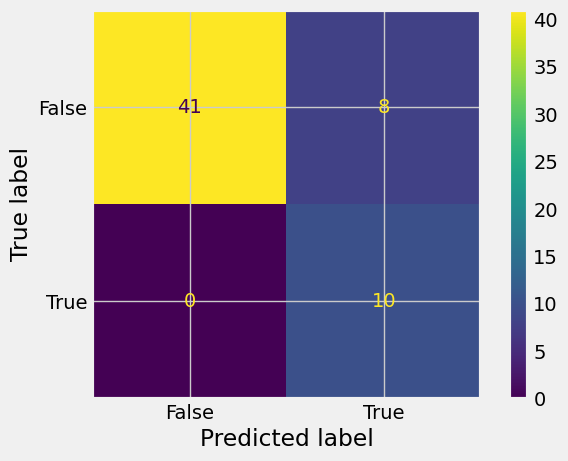

In [42]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

## Feature Importance (Optional)

In [43]:
features = x_df.columns
importances_cboost = cboost.feature_importances_

In [44]:
cboost_results = {'accuracy': accuracy,
                  'model': 'CatBoost',
                  'f1_score': F1,
                  'training auc score': train_auc,
                  'test auc score': test_auc}
cboost_results

{'accuracy': 0.864406779661017,
 'model': 'CatBoost',
 'f1_score': 0.7142857142857143,
 'training auc score': 0.9903553360347184,
 'test auc score': 0.9653061224489796}

After removing those features.
* f1 score fell below from 51 to 45.
* Overfitting reduced.

### K-fold cross validation (Optional)

To use K-fold cross validation, training data file can be split into train and test sets using train_test_split method.

In [45]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)

In [46]:
for k, (train, test) in enumerate(kfold.split(x_df, y_df)):
    cboost.fit(x_df.iloc[train], y_df.iloc[train])
    print(f'iteration number = {k+1}')
    print(f'Training Accuracy = {cboost.score(x_df.iloc[train], y_df.iloc[train])}')
    print(f'Test Accuracy = {cboost.score(x_df.iloc[test], y_df.iloc[test])}')
    print(f'f1 score = {f1_score(test_y, predictions)}')

Streaming output truncated to the last 5000 lines.
20:	learn: 0.4440987	total: 18ms	remaining: 838ms
21:	learn: 0.4390772	total: 18.7ms	remaining: 833ms
22:	learn: 0.4345328	total: 19.6ms	remaining: 832ms
23:	learn: 0.4311096	total: 20.3ms	remaining: 824ms
24:	learn: 0.4273136	total: 21.1ms	remaining: 824ms
25:	learn: 0.4242277	total: 22.1ms	remaining: 829ms
26:	learn: 0.4201269	total: 22.7ms	remaining: 819ms
27:	learn: 0.4157636	total: 23.4ms	remaining: 813ms
28:	learn: 0.4124658	total: 24ms	remaining: 803ms
29:	learn: 0.4085123	total: 25.1ms	remaining: 812ms
30:	learn: 0.4050363	total: 25.7ms	remaining: 803ms
31:	learn: 0.4015359	total: 26.4ms	remaining: 798ms
32:	learn: 0.3986845	total: 27ms	remaining: 791ms
33:	learn: 0.3955680	total: 27.8ms	remaining: 789ms
34:	learn: 0.3925338	total: 28.6ms	remaining: 788ms
35:	learn: 0.3894753	total: 29.6ms	remaining: 792ms
36:	learn: 0.3872925	total: 30.1ms	remaining: 784ms
37:	learn: 0.3852928	total: 30.9ms	remaining: 783ms
38:	learn: 0.383266

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost

**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [47]:
# Copy dataframe
xgb_data = train_ibm_df.copy()

In [48]:
# Handling categorical features
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)
xgb_dummy.head()

,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition_Yes
91,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
815,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1096,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False
303,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
318,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [49]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
xgb_data = pd.concat([xgb_data, xgb_dummy], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.head(5)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition_Yes
91,33,536,10,5,4,82,4,3,3,8380,21708,0.0,14,3,4,80,2.0,10.0,3.0,3,9,8.0,0.0,8.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
815,29,1329,7,3,3,82,3,2,4,6623,4204,1.0,11,3,2,80,2.0,6.0,2.0,3,6,0.0,1.0,0.0,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1096,59,1089,1,2,2,66,3,3,4,11904,11038,3.0,14,3,3,80,1.0,14.0,1.0,1,6,4.0,0.0,4.0,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False
303,46,1034,18,1,1,86,3,3,3,10527,8984,5.0,11,3,4,80,0.0,28.0,3.0,2,2,2.0,1.0,2.0,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
318,33,575,25,3,4,44,2,2,2,4320,24152,1.0,13,3,4,80,0.0,5.0,2.0,3,5,3.0,0.0,2.0,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [50]:
# Rename target column
xgb_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
xgb_data.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition
91,33,536,10,5,4,82,4,3,3,8380,21708,0.0,14,3,4,80,2.0,10.0,3.0,3,9,8.0,0.0,8.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
815,29,1329,7,3,3,82,3,2,4,6623,4204,1.0,11,3,2,80,2.0,6.0,2.0,3,6,0.0,1.0,0.0,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1096,59,1089,1,2,2,66,3,3,4,11904,11038,3.0,14,3,3,80,1.0,14.0,1.0,1,6,4.0,0.0,4.0,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True,False
303,46,1034,18,1,1,86,3,3,3,10527,8984,5.0,11,3,4,80,0.0,28.0,3.0,2,2,2.0,1.0,2.0,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
318,33,575,25,3,4,44,2,2,2,4320,24152,1.0,13,3,4,80,0.0,5.0,2.0,3,5,3.0,0.0,2.0,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


In [51]:
# Features
x_df = xgb_data.drop('attrition', axis=1)
# Targer label
y_df = xgb_data['attrition']

x_df.shape, y_df.shape

((1111, 45), (1111,))

In [52]:
x_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
91,33,536,10,5,4,82,4,3,3,8380,21708,0.0,14,3,4,80,2.0,10.0,3.0,3,9,8.0,0.0,8.0,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
815,29,1329,7,3,3,82,3,2,4,6623,4204,1.0,11,3,2,80,2.0,6.0,2.0,3,6,0.0,1.0,0.0,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
1096,59,1089,1,2,2,66,3,3,4,11904,11038,3.0,14,3,3,80,1.0,14.0,1.0,1,6,4.0,0.0,4.0,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,True
303,46,1034,18,1,1,86,3,3,3,10527,8984,5.0,11,3,4,80,0.0,28.0,3.0,2,2,2.0,1.0,2.0,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
318,33,575,25,3,4,44,2,2,2,4320,24152,1.0,13,3,4,80,0.0,5.0,2.0,3,5,3.0,0.0,2.0,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False


Unlike LightGBM, in XGB, one has to manually create dummy variable/ label encoding for categorical features before feeding them into the models

### SMOTE (Optional)

In [53]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

<Axes: ylabel='count'>

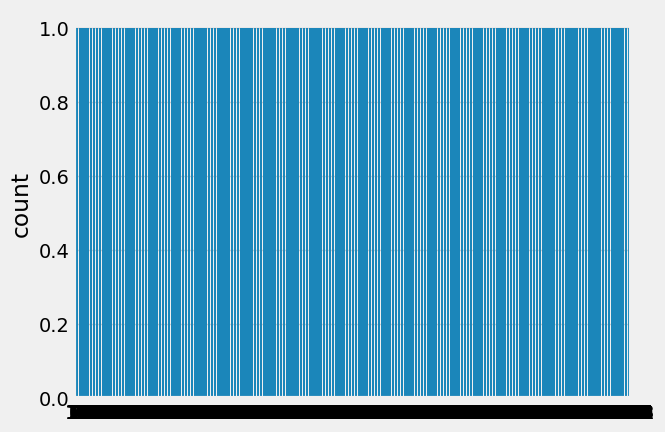

In [54]:
sns.countplot(y_df1, label = 'count')

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

In [55]:
# def xgb_objective(space):

#     model = XGBClassifier(
#         learning_rate = space['learning_rate'],
#         n_estimators = int(space['n_estimators']),
#         max_depth = int(space['max_depth']),
#         min_child_weight = space['m_child_weight'],
#         gamma = space['gamma'],
#         subsample = space['subsample'],
#         scale_pos_weight = 6,
#         colsample_bytree = space['colsample_bytree'],
#         objective = 'binary:logistic'
#     )

#     model.fit(x_df, y_df)

#     predictions = model.predict(test_x)
#     test_preds = model.predict_proba(test_x)[:,1]
#     train_preds = model.predict_proba(x_df)[:,1]

#     xgb_booster = model.get_booster()
#     train_auc = roc_auc_score(y_df, train_preds)
#     test_auc = roc_auc_score(test_y, test_preds)
#     accuracy = accuracy_score(test_y, predictions)
#     F1 = f1_score(test_y, predictions)

#     return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
#             'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1
#            }

In [56]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

In [57]:
trials = Trials()

In [58]:
# xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
# display(xgb_results)

In [59]:
# Create XGBoost classifier model
xgb_model = XGBClassifier(
    learning_rate = 0.14972574734435318,
    n_estimators = 200,
    max_depth = 1,
    min_child_weight = 6,
    gamma = 0.5,
    subsample = 0.55,
    colsample_bytree = 1,
    scale_pos_weight = 6,
    objective = 'binary:logistic'
)

In [60]:
x_df.shape, y_df.shape

((1111, 45), (1111,))

In [61]:
xgb_model.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14972574734435318, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
xgb_model_dft = XGBClassifier()

In [63]:
xgb_model_dft.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Model Performance

In [64]:
# Model performance on all sets
predictions = xgb_model.predict(test_x)
test_preds = xgb_model.predict_proba(test_x)[:,1]
train_preds = xgb_model.predict_proba(x_df)[:,1]

xgb_booster = xgb_model.get_booster()

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [65]:
F1 = f1_score(test_y, predictions)
print(F1)

0.6896551724137931


Confusion Matrix

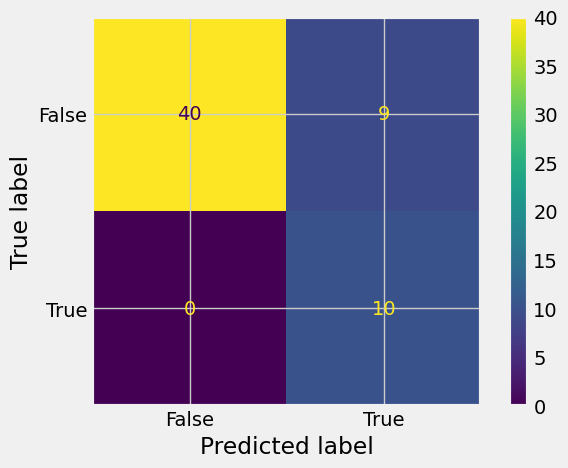

In [66]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

### Feature Importance

In [67]:
features = x_df.columns
importances_xgboost = xgb_model.feature_importances_

In [68]:
xgb_results = {'accuracy': accuracy,
              'model': 'XGBoost',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}
xgb_results

{'accuracy': 0.847457627118644,
 'model': 'XGBoost',
 'f1_score': 0.6896551724137931,
 'test auc score': 0.9673469387755103,
 'training auc score': 0.9155237729877478}

f1 score fell below, from 51 to 50.
* Overfitting is unaffected.

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [69]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
lgb_data = train_ibm_df.copy()

# Handling categorical features
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)

# Concat the dummy variables to actual dataframe and remove initial categorical columns
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)

# Rename target column
lgb_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)

# Features
x_df = lgb_data.drop(columns='attrition')
# Target lebel
y_df = lgb_data['attrition'].reset_index(drop=True)
x_df.shape, y_df.shape

((1111, 45), (1111,))

<Axes: ylabel='count'>

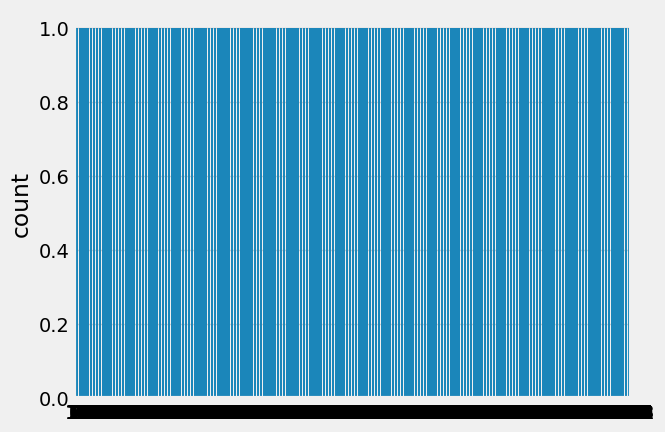

In [70]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)
sns.countplot(y_df1, label = 'count')

### Model Definition

In [71]:
def lgb_objective(space):

    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        scale_pos_weight = 5,
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )

    lgbm.fit(x_df, y_df)

    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(x_df)[:,1]

    train_auc = roc_auc_score(y_df, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1

           }

In [72]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective,
                 max_evals = 5,
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

[LightGBM] [Warning] feature_fraction is set=0.759070124253403, colsample_bytree=0.3008530105390063 will be ignored. Current value: feature_fraction=0.759070124253403
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.759070124253403, colsample_bytree=0.3008530105390063 will be ignored. Current value: feature_fraction=0.759070124253403
[LightGBM] [Info] Number of positive: 179, number of negative: 932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161116 -> initscore=-1.649947
[LightGBM] [Info] Start training from score -1.649947
[LightGBM] [Warning] No further s

{'model': 'LightGBM',
 'parameter search time': '0:00:23.914000',
 'accuracy': 0.169,
 'f1_score': 0.29,
 'test auc score': 0.405,
 'training auc score': 0.999,
 'parameters': {'colsample_bytree': 0.7456290945611137,
  'feature_fraction': 0.3559437785053082,
  'learning_rate': 0.02511111808771595,
  'max_depth': 7.0,
  'min_split_gain': 0.04549197582076642,
  'n_estimators': 200.0,
  'num_leaves': 85.0,
  'reg_alpha': 0.8964062016375653,
  'reg_lambda': 0.4214481526419148}}

In [73]:
# # Create LightGBM classifier model
# lgbm = LGBMClassifier(
#     learning_rate = 0.15828893812295405,
#     n_estimators= 825,
#     max_depth = 8,
#     num_leaves = 110,
#     colsample_bytree = 0.6839759118900923,
#     feature_fraction = 0.3930665137463929,
#     reg_lambda = 0.8857198279892347,
#     reg_alpha = 0.8003856547872137,
#     min_split_gain = 0.07737786522996747
# )

In [74]:
# Create LightGBM classifier model
lgbm = LGBMClassifier(
    learning_rate = 1,
    n_estimators= 100,
    max_depth = 3,
    num_leaves = 31,
    colsample_bytree = 1,
    reg_lambda = 30,
    scale_pos_weight = 5,
    reg_alpha = 30,
    min_split_gain = 3
)

In [75]:
lgbm.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 179, number of negative: 932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161116 -> initscore=-1.649947
[LightGBM] [Info] Start training from score -1.649947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(colsample_bytree=1, learning_rate=1, max_depth=3,
               min_split_gain=3, reg_alpha=30, reg_lambda=30,
               scale_pos_weight=5)

In [76]:
lgbm_dft = LGBMClassifier()

In [77]:
lgbm_dft.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 179, number of negative: 932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161116 -> initscore=-1.649947
[LightGBM] [Info] Start training from score -1.649947


LGBMClassifier()

### Model performance

In [78]:
# Model performance on all sets
predictions = lgbm.predict(test_x)
test_preds = lgbm.predict_proba(test_x)[:,1]
train_preds = lgbm.predict_proba(x_df1)[:,1]

train_auc = roc_auc_score(y_df1, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [79]:
F1 = f1_score(test_y, predictions)
print(F1)

0.0


Confusion Matrix

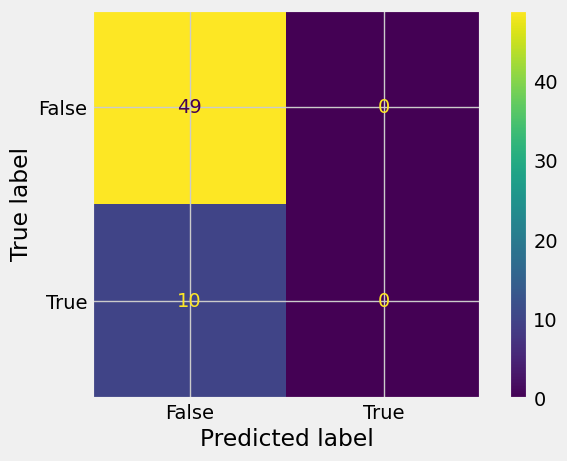

In [80]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

## Feature Importance

In [81]:
features = x_df.columns
importances_lgbm = lgbm.feature_importances_

In [82]:
lgbm_results = {'accuracy': accuracy,
              'model': 'LightGBM',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}

lgbm_results

{'accuracy': 0.8305084745762712,
 'model': 'LightGBM',
 'f1_score': 0.0,
 'test auc score': 0.5255102040816326,
 'training auc score': 0.8190810983808874}

f1 score drastically fell.
* Overfiiting is unaffected.

### Importances Dataframe

In [83]:
importances_cboost

array([6.95305124, 5.73042954, 3.02708581, 0.82764899, 2.05502501,
       7.33454294, 2.33473258, 4.85698282, 2.17864626, 7.43267991,
       9.12940608, 3.08048948, 1.79895896, 0.        , 1.19964446,
       0.        , 3.68399432, 2.86997457, 1.54100928, 2.43239793,
       3.86114715, 3.28775748, 1.58706359, 4.22694811, 2.78907791,
       0.68284597, 0.02076798, 2.73888611, 0.34585906, 0.24602985,
       0.12379632, 0.12081057, 1.36499793, 0.37300526, 0.25901275,
       0.48789835, 0.        , 0.02302602, 0.52841852, 1.01049294,
       0.2030521 , 0.02453285, 0.03545426, 0.59492626, 6.59749249])

In [84]:
print(np.round(importances_xgboost*100))

[4. 2. 3. 2. 3. 2. 3. 3. 4. 4. 2. 3. 2. 0. 2. 0. 5. 3. 2. 3. 4. 3. 3. 3.
 3. 0. 2. 5. 2. 3. 2. 0. 2. 0. 0. 2. 0. 3. 0. 3. 1. 0. 0. 3. 5.]


In [85]:
importances_lgbm

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0,
       0], dtype=int32)

In [86]:
print(np.round(importances_cboost))

[7. 6. 3. 1. 2. 7. 2. 5. 2. 7. 9. 3. 2. 0. 1. 0. 4. 3. 2. 2. 4. 3. 2. 4.
 3. 1. 0. 3. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 7.]


In [87]:
importances_df = pd.DataFrame()
importances_df['Feature Name'] = features
importances_df['Feature Imp CBoost'] = np.round(importances_cboost)
importances_df['Feature Imp XGBoost'] = np.round(importances_xgboost*100)
importances_df['Feature Imp LightBoost'] = importances_lgbm
importances_df.sort_values(['Feature Imp CBoost', 'Feature Imp XGBoost', 'Feature Imp LightBoost'], ascending=False)

,Feature Name,Feature Imp CBoost,Feature Imp XGBoost,Feature Imp LightBoost
10,jobrole_Human Resources,9.0,2.0,0
44,yearswithcurrmanager,7.0,5.0,0
0,businesstravel_Travel_Frequently,7.0,4.0,1
9,gender_Male,7.0,4.0,0
5,educationfield_Marketing,7.0,2.0,0
1,businesstravel_Travel_Rarely,6.0,2.0,0
7,educationfield_Other,5.0,3.0,0
16,jobrole_Sales Executive,4.0,5.0,0
20,overtime_Yes,4.0,4.0,1
23,distancefromhome,4.0,3.0,1


## Results

**Exercise 12: Create a dataframe of XGBoost results, LightGBM results, CatBoost results and display them [0.5 Mark]**

In [88]:
# Create a dataframe for computed metrics for different models
final_results = pd.DataFrame([xgb_results, lgbm_results, cboost_results])
display(final_results)

,accuracy,model,f1_score,test auc score,training auc score
0,0.847458,XGBoost,0.689655,0.967347,0.915524
1,0.830508,LightGBM,0.000000,0.525510,0.819081
2,0.864407,CatBoost,0.714286,0.965306,0.990355


- XGBoost is a wonderful algorithm with great documentation and many examples from years of use.
- LightGBM was clearly the fastest algorithm, often being 10x faster than XGBoost.
- In terms of accuracy the test and train dataset often had different balances of minority and majority class so 1-to-1 comparisons aren't perfect.
- CatBoost was the algorithm one can be most interested in using because of the supposed innovations in working with categorical data. Despite good accuracy however, several problems were faced.

    - CatBoost seemed significantly slower than the other algorithms, it seemed to stall on some evaluations. More experimentation may be needed with CatBoost and data that had lots of categorical features to get a better feel for when it may perform best.

* SMOTE was used to handle imabalance, it had no effect on the performance of all the three models.
* Using POS weight parameter to handle imabalace in all the three models helps give good results.
* K-fold cross validation technique was used while using train test split, performance of the model dipped.
* Outliers were handled but it had least effect on the performance.
* Three irrelevant features were dropped, it had no effect on the model performance.
* By far CatBoost is the best performing model followed by XGBoost whereas CatBoost takes longer to optimize parameters using Hyperopt, it is quick with XGBoost.
* Feature importance was calculated for all the three models.
* Based upon the importance 5 features were identified as not important. Removing these features while training dipped the performance of the models.

References:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

## Kaggle Prediction

Load data from Kaggle competition site

In [89]:
kaggle_test = pd.read_csv("/content/hr_employee_attrition_test.csv")
kaggle_test.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/hr_employee_attrition_test.csv'

In [ ]:
kaggle_test.shape

In [ ]:
# Drop columns having single value
test_df = kaggle_test.drop(['id','employeenumber', 'employeecount', 'over18'], axis=1)
test_df.head()

In [ ]:
test_df.shape

In [ ]:
categorical

In [ ]:
# Handling categorical features
dummy = pd.get_dummies(test_df[categorical[:7]], drop_first=True)
dummy.head()

In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
test_df1 = pd.concat([test_df, dummy], axis=1)
test_df1.drop(columns = categorical[:7], inplace=True)
test_df1.head()

In [ ]:
test_df1.shape

Predictions

In [ ]:
cboost_preds = cboost.predict(test_df1)
cboost_preds

In [ ]:
xgb_preds = xgb_model.predict(test_df1)
xgb_preds

In [ ]:
lgbm_preds = lgbm.predict(test_df1)
lgbm_preds

Save predictions to csv

In [ ]:
save_df = pd.DataFrame({'id': kaggle_test['id'],
                        'label': cboost_preds})
save_df.head()

In [ ]:
save_df.to_csv("predictions.csv", index=False)

In [ ]:
g_truth = pd.read_csv("/content/ground_truth.csv")
g_truth.head()

In [ ]:
f1_score(g_truth.label, cboost_preds)

In [ ]:
f1_score(g_truth.label, xgb_preds)

In [ ]:
f1_score(g_truth.label, lgbm_preds)

In [ ]:
f1_score(g_truth.label, cboost_dft.predict(test_df1))

In [ ]:
f1_score(g_truth.label, xgb_model_dft.predict(test_df1))

In [ ]:
f1_score(g_truth.label, lgbm_dft.predict(test_df1))